<a href="https://colab.research.google.com/github/PabloViniciusSS/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
class Value:

  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda:None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) #Para poder instância um valor sem o adicionar a classe Value
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) #Para poder instância um valor sem o adicionar a classe Value
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

  def __rmul__(self, other): #other * self. Python não identifica se multiplicar um valor à direita e um valor da classe Value, apra resolver isso utilizamos o código abaixo
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L

Value(data=-8.0)

In [4]:
from graphviz import Digraph

def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'randir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
      uid = str(id(n))
      dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

      if n._op:

        dot.node(name = uid + n._op, label = n._op)

        dot.edge(uid + n._op, uid)

    for n1, n2 in edges:

      dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


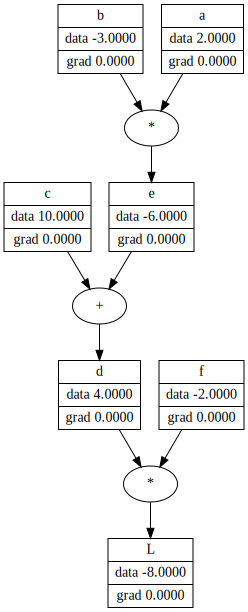

In [ ]:
draw_dot(L)

In [ ]:
a.grad= 6
b.grad=-4
c.grad=-2
e.grad=-2
d.grad=-2
f.grad=4


In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data


  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  print((L2-L1)/h) #Calculo da derivada de L
lol()

1.000000000000334


In [ ]:
L.grad = 1.0

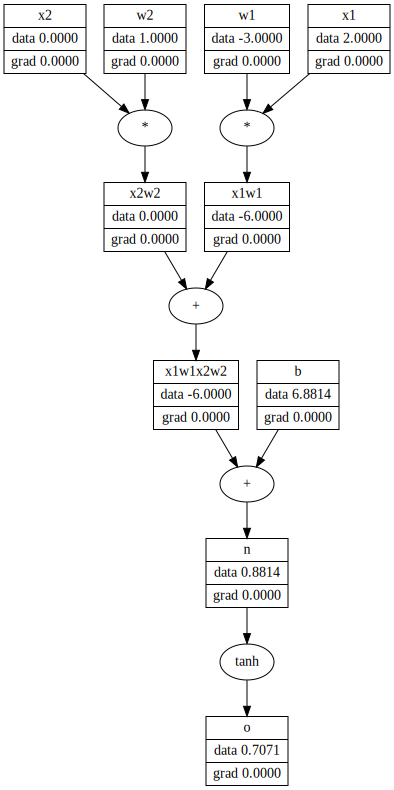

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#pesos w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#vies dos neuronios
b = Value(6.8813735870195432, label='b')
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

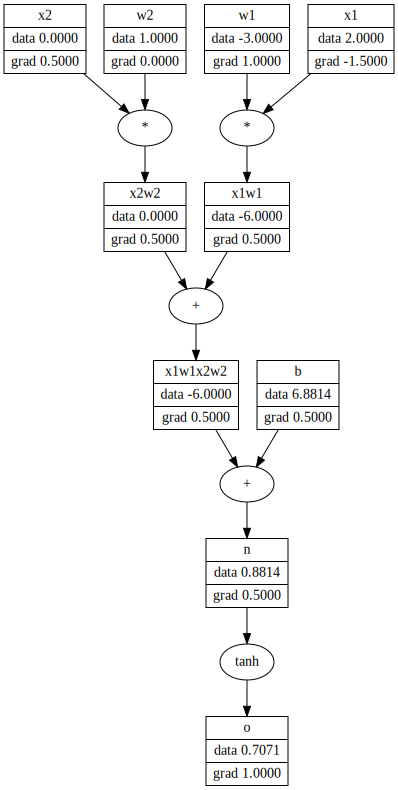

In [ ]:
draw_dot(o)

In [ ]:
o.grad=1.0

In [ ]:
o.backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
#Para o backward propagation ir corretamente sem haver pulo, vamos fazer uma arvore
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

# Derivada de n

In [ ]:
# o = tanh(n)
# do/dn = 1 - o ** 2
# do/dn = 1 - o.data**2
n.grad = 0.5

In [ ]:
1 - o.data**2

0.4999999999999999

### Derivada de x1w1x2w2, b e x1w1 e x2w2

> Nó positivo: sendo um sinal de + é apenas um distribuidos de gradiente, assim sendo, a derivada de n vai fluir para os pontos onde o nó é positivo.




In [ ]:
#Como é um nó positivo a derivada de n flui para os dois pontos existentes nesse nó
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
#Como é um nó positivo a derivada de n flui para os dois pontos existentes nesse nó
x1w1.grad = 0.5
x2w2.grad = 0.5

### Derivada de x2, w2, x1, w1

> Utilizando a regra de cadeira local, para descobrimo o x = w * derivada de xw e a dereivada de w = x * a derivada de xw



In [ ]:
x2.grad= w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
# o = tanh(n)
# do/dn = 1 - o ** 2

# Problema de backward propagation

Se o nó recebe mais de uma ação, o gradiente dele é somado duas vezes

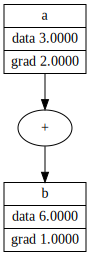

In [7]:
a = Value(3.0, label ='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

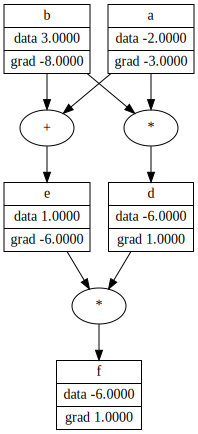

In [10]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)